# Phenopacket store statistics

This notebook performs quality assessment and calculate descriptive statistics about a phenopacket-store release. 

The input file is the zip file that is or will be added to each release.

In [1]:
from ppktstore.stats import PPKtStoreStats
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
stats = PPKtStoreStats(input_zipfile="all_phenopackets.zip")

In [3]:
df = stats.get_df()
df.head()

,disease,disease_id,patient_id,gene,allele_1,allele_2,PMID
0,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual KCHYD24-1,ESAM,NM_138961.3:c.605T>G,,PMID:36996813
1,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual 1,ESAM,NM_138961.3:c.115del,,PMID:36996813
2,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual 13,ESAM,NM_138961.3:c.451+1G>A,,PMID:36996813
3,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual 7,ESAM,NM_138961.3:c.115del,,PMID:36996813
4,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual 12,ESAM,NM_138961.3:c.451+1G>A,,PMID:36996813


In [4]:
stats_d = stats.get_descriptive_stats()
for k,v in stats_d.items():
    print(k,v)

phenopackets 4188
diseases 386
genes 343
alleles 2054
PMIDs 616
individuals per disease (max) 464
individuals per disease (min) 1
individuals per disease (mean) 10.849740932642487
individuals per disease (median) 1.0
individuals per disease (n>=10) 88
individuals per disease (n>=20) 45
individuals per disease (n>=50) 18
individuals per disease (n>=100) 6
genes associated with a single disease 321
genes associated with two diseases 13
genes associated with multiple diseases 22
gene with maximum number of diseases SCO2 with 7 associated diseases
individuals per gene (max) 464
individuals per gene (min) 1
individuals per gene (mean) 12.209912536443149
individuals per gene (median) 1.0
individuals per gene (n>=10) 69
individuals per gene (n>=20) 42
individuals per gene (n>=50) 20
individuals per gene (n>=100) 8


In [5]:
counts_per_disease = stats.get_counts_per_disease()
counts_per_disease.head()

disease_id
OMIM:612164    464
OMIM:613721    343
OMIM:148050    328
OMIM:613826    191
OMIM:615471    125
Name: count, dtype: int64

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_with_max(
        disease_counts: pd.Series,
        max_val: int,
        ax=None,
        ):
    assert isinstance(max_val, int) and max_val > 0, '`max_val` must be a positive `int`'

    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4), dpi=300)

    bins = list(range(max_val + 1)) + [disease_counts.max() + 1]
    labels = list(map(str, bins[:-2])) + [f'  ≥{max_val}']
    cats = pd.cut(
        x=disease_counts,
        bins=bins,
        labels=labels,
        right=False,
    )
    cat_count = cats.value_counts().sort_index()
    ax.bar(x=cat_count.index, height=cat_count.values)
    ax.set(
        xlabel='Number of cases',
        ylabel='Disease count',
    )
    ax.grid(axis='y')


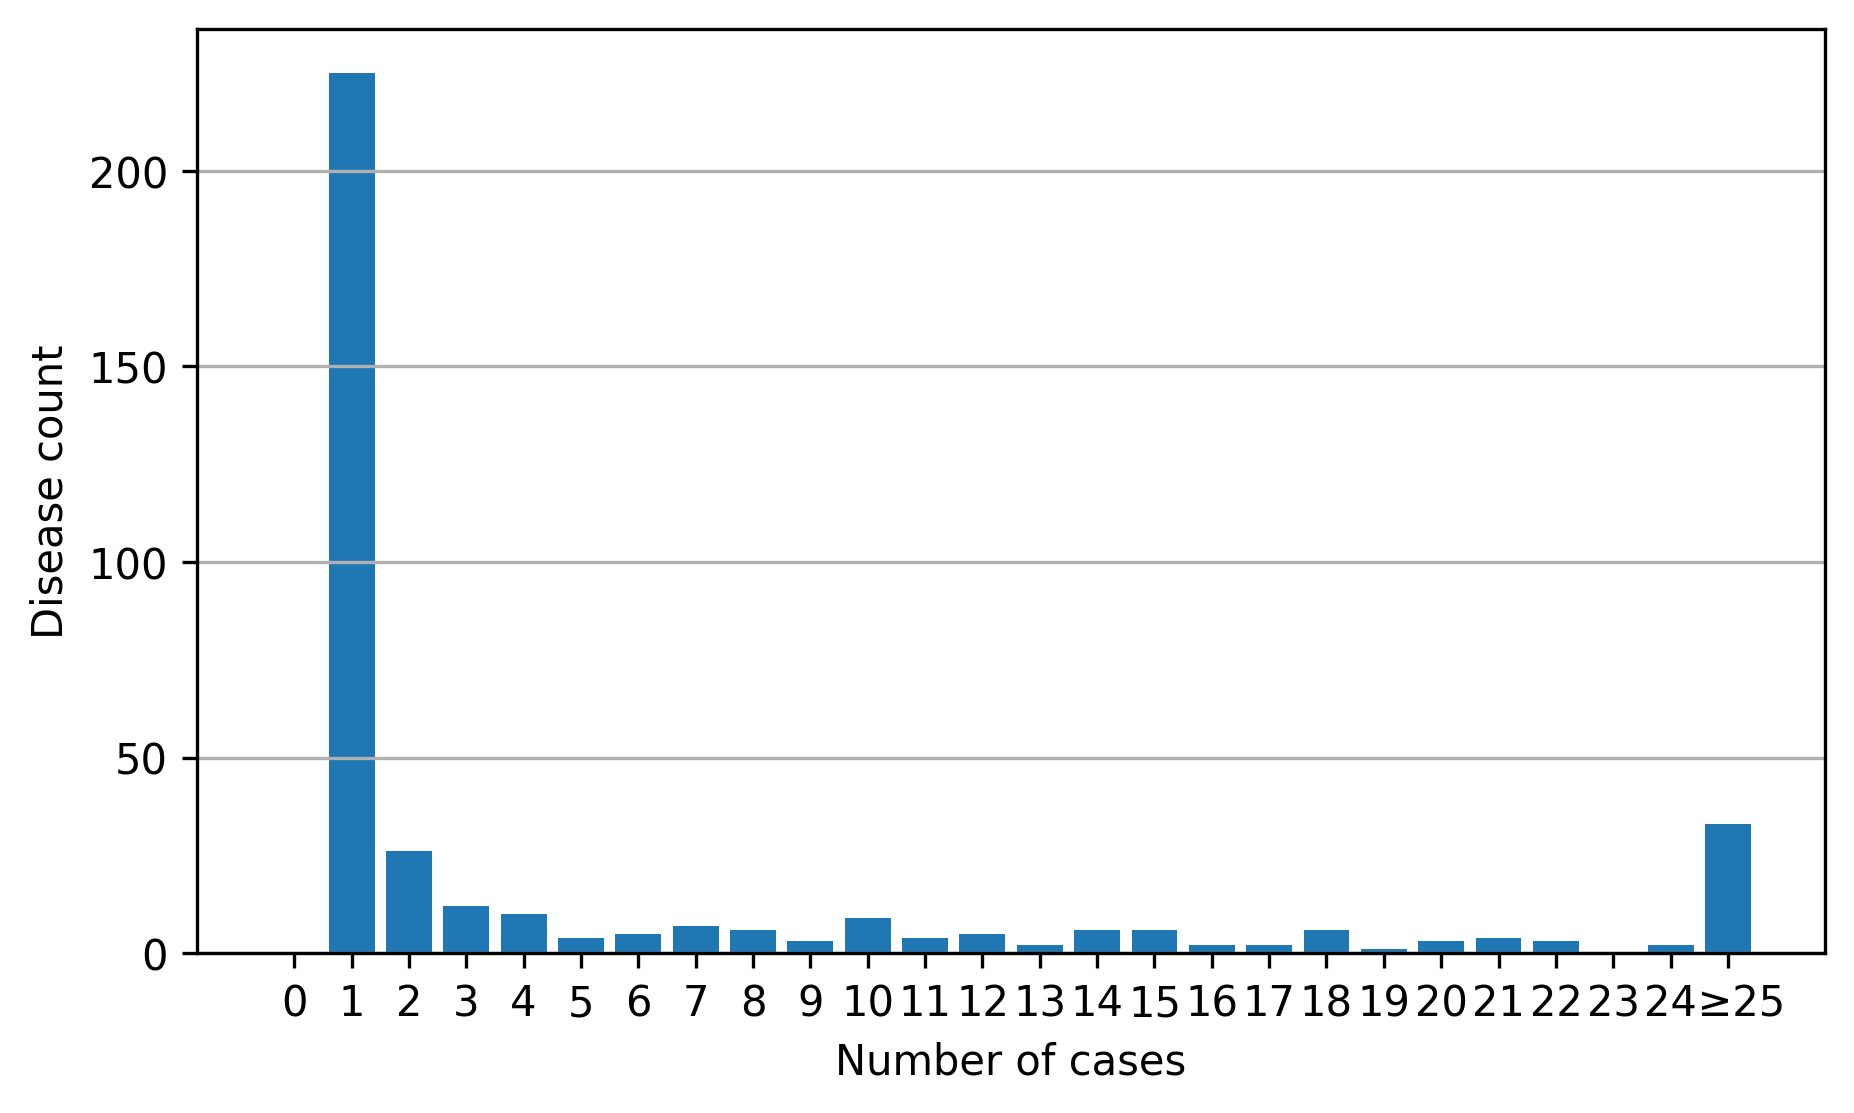

In [7]:
plot_with_max(
    disease_counts=counts_per_disease,
    max_val=25,
)

# Check all disease identifiers
They should all be CURIEs with the prefixes OMIM or MONDO. There should be no whitespace between the colon and the suffix.

In [8]:
df = stats.check_disease_id()

Found 20 problematic disease identifiers


In [9]:
df.head(20)

,disease_id,label,individual_id,PMID
0,OMIM: 146510,Pallister-Hall syndrome,Grand-mother,PMID:24736735
1,OMIM: 146510,Pallister-Hall syndrome,Aunt,PMID:24736735
2,OMIM: 146510,Pallister-Hall syndrome,P15112,PMID:24736735
3,OMIM:612778a,SETD2-Sotos-like,4,PMID:33766796
4,OMIM:612778b,SETD2-Autism spectrum disorder,5,PMID:33766796
5,OMIM:612778b,SETD2-Autism spectrum disorder,11,PMID:33766796
6,OMIM:612778b,SETD2-Autism spectrum disorder,3,PMID:33766796
7,OMIM:612778b,SETD2-Autism spectrum disorder,17,PMID:33766796
8,OMIM:612778b,SETD2-Autism spectrum disorder,19,PMID:33766796
9,OMIM:612778a,SETD2-Sotos-like,12,PMID:33766796


# Count diseases in cohort
In phenopacket-store, each of the folders underneath the "notebooks" folder is counted as a cohort. The following function can be used to 
display the count of diseases in a specific cohort. The intended use case is that in time we would like to move the LIRICAL phenopackets into gene-specific cohorts.

In [10]:
input_zipfile = "all_phenopackets.zip"
target = "LIRICAL"
df = stats.count_diseases_in_cohort(input_zipfile=input_zipfile, cohort=target)
df.head(50)

,label,count
disease_id,,
OMIM:616900,"Hypotonia, infantile, with psychomotor retardation and characteristic facies 3",19
OMIM:616975,"Neurodevelopmental disorder with or without anomalies of the brain, eye, or heart",18
OMIM:616907,"Spastic paraplegia 76, autosomal recessive",12
OMIM:159550,Ataxia-pancytopenia syndrome,10
OMIM:617425,Immunoskeletal dysplasia with neurodevelopmental abnormalities,10
OMIM:617560,"Spastic ataxia 8, autosomal recessive, with hypomyelinating leukodystrophy",7
OMIM:616829,"Congenital disorder of glycosylation, type IIp",6
OMIM:616878,"Metabolic encephalomyopathic crises, recurrent, with rhabdomyolysis, cardiac arrhythmias, and neurodegeneration",6
OMIM:154700,MARFAN SYNDROME; MFS,4


# Check for duplicates
In some cases, duplicate phenopackets were inadvertently added to some of the initial cohorts at earlier stages of the project. This function lists phenopacket identifers arranged according to variant and allows us to more easily check for this kind of error.

In [11]:
df = stats.show_possible_duplicates_by_variant(input_zipfile, "ERI1")

In [12]:

df.head(85)

,variant,individual_id
0,NM_153332.4:c.514C>T,PMID_37352860_5
1,NM_153332.4:c.514C>T,PMID_37352860_Individual_5
2,NM_153332.4:c.352A>T,PMID_37352860_Hoxha
3,NM_153332.4:c.352A>T,PMID_37352860_Individual_Hoxha
4,g.8783887_9068578del,PMID_37352860_Individual_Choucair
5,g.8783887_9068578del,PMID_37352860_Choucair
6,NM_153332.4:c.464C>T,PMID_37352860_4
7,NM_153332.4:c.464C>T,PMID_37352860_2
8,NM_153332.4:c.464C>T,PMID_37352860_Individual_4
9,NM_153332.4:c.464C>T,PMID_37352860_Individual_2


# Check for entries with no variants
phenopacket-store focuses on Mendelian diseases and includes only phenopackets for cases in which the causal variant was identified. A phenopacket with no variant is thus considered an error. The following function searches for such phenopackets.

In [13]:
df = stats.find_phenopackets_with_no_variants(input_zipfile=input_zipfile)

[WARNING] could not find variant for phenopacket PMID:26590883-Savage-2016-FANCI-NCI-309-1
[WARNING] could not find variant for phenopacket PMID:26590883-Savage-2016-FANCI-NCI-309-1
[WARNING] could not find variant for phenopacket PMID:28620732-Gowda-2017-MCOLN1-6_year_old_boy
[WARNING] could not find variant for phenopacket PMID:9233564-Holmberg-1997-GP1BA-73_year_old_male
[WARNING] could not find variant for phenopacket PMID:29146883-Bluteau-2018-SAMD9L-UB085
[WARNING] could not find variant for phenopacket PMID:28242392-Jiang-2017-PPIB-second_fetus
[WARNING] could not find variant for phenopacket PMID:28242392-Jiang-2017-PPIB-second_fetus
[WARNING] could not find variant for phenopacket PMID:30103036-Zapata-Aldana-2019-TBCK-Patient_2
[WARNING] could not find variant for phenopacket PMID:20932317-Truong-2010-RAI1-SMS324
[WARNING] could not find variant for phenopacket PMID:9354794-Gebbia-1997-ZIC3-III-1
[WARNING] could not find variant for phenopacket PMID:27374306-Pipilas-2016-CALM1

In [14]:
df.head()

,cohort,phenopacket
0,ANKH/,PMID_22647861_41-year-old_woman
1,LIRICAL/,PMID:26590883-Savage-2016-FANCI-NCI-309-1
2,LIRICAL/,PMID:28620732-Gowda-2017-MCOLN1-6_year_old_boy
3,LIRICAL/,PMID:9233564-Holmberg-1997-GP1BA-73_year_old_male
4,LIRICAL/,PMID:29146883-Bluteau-2018-SAMD9L-UB085


In [18]:
df = stats.show_cohorts_with_possible_duplicates(input_zipfile=input_zipfile)

11q_terminal_deletion/
ABCB7/
ACTB/
ADAMTS15/
ANKH/
ANKRD11/
ARPC5/
ATP13A2/
ATP6V0C/
AXIN1/
BRD4/
CBLB/
CLXN/
COL3A1/
COQ7/
DBR1/
DEPDC5/
DOCK8/
EIF4A2/
ERI1/
ESAM/
EZH1/
FBN1/
FBXL4/
GABBR1/
GCSH/
GLI3/
GNAO1/
HMGCR/
HNRNPC/
HNRPA2B1/
INTS11/
ISCA2/
KCNH5/
KDM6B/
LIRICAL/
[WARNING] could not find variant for phenopacket PMID:26590883-Savage-2016-FANCI-NCI-309-1
[WARNING] could not find variant for phenopacket PMID:26590883-Savage-2016-FANCI-NCI-309-1
[WARNING] could not find variant for phenopacket PMID:28620732-Gowda-2017-MCOLN1-6_year_old_boy
[WARNING] could not find variant for phenopacket PMID:9233564-Holmberg-1997-GP1BA-73_year_old_male
[WARNING] could not find variant for phenopacket PMID:29146883-Bluteau-2018-SAMD9L-UB085
[WARNING] could not find variant for phenopacket PMID:28242392-Jiang-2017-PPIB-second_fetus
[WARNING] could not find variant for phenopacket PMID:28242392-Jiang-2017-PPIB-second_fetus
[WARNING] could not find variant for phenopacket PMID:30103036-Zapata-Aldan

In [16]:
df

,variant,individual_id,cohort
0,telomeric 11q deletion,PMID_15266616_35,11q_terminal_deletion/
1,telomeric 11q deletion,PMID_15266616_148,11q_terminal_deletion/
2,telomeric 11q deletion,PMID_15266616_7,11q_terminal_deletion/
3,telomeric 11q deletion,PMID_15266616_19,11q_terminal_deletion/
4,telomeric 11q deletion,PMID_15266616_81,11q_terminal_deletion/
5,telomeric 11q deletion,PMID_15266616_113,11q_terminal_deletion/
6,telomeric 11q deletion,PMID_15266616_105,11q_terminal_deletion/
7,telomeric 11q deletion,PMID_15266616_97,11q_terminal_deletion/
8,telomeric 11q deletion,PMID_15266616_152,11q_terminal_deletion/
9,telomeric 11q deletion,PMID_15266616_129,11q_terminal_deletion/


In [17]:
stats.show_phenopackets_with_gene(input_zipfile=input_zipfile, cohort="LIRICAL", gene_symbol="ROR2"  )

,gene,phenopacket
0,ROR2,PMID:24932600-Tamhankar-2014-ROR2-Patient_1
1,ROR2,PMID:24932600-Tamhankar-2014-ROR2-Patient_2


# Cohorts to check
Next archive version
ANKH
-COL3A1
-ERI1
-FBN1



In [102]:
stats.show_possible_duplicates_by_variant(input_zipfile, "ZSWIM6")

,variant,individual_id
0,NM_020928.2:c.3487C>T,individual_4
1,NM_020928.2:c.3487C>T,PMID_25105228_Individual_4
2,NM_020928.2:c.3487C>T,individual_2
3,NM_020928.2:c.3487C>T,PMID_25105228_Individual_3
4,NM_020928.2:c.3487C>T,PMID_25105228_Individual_2
5,NM_020928.2:c.3487C>T,PMID_26706854_1-1
6,NM_020928.2:c.3487C>T,individual_3
7,NM_020928.2:c.3487C>T,PMID_26706854_Subject_1-1
8,NM_020928.2:c.3487C>T,PMID_26706854_2
9,NM_020928.2:c.3487C>T,PMID_26706854_Subject_1-2
